<a href="https://akademie.datamics.com/kursliste/">![title](bg_datamics_top.png)</a>

<center><em>© Datamics</em></center><br><center><em>Besuche uns für mehr Informationen auf <a href='https://akademie.datamics.com/kursliste/'>www.akademie.datamics.com</a></em></center>

# MNIST mit Multi-Layer Perceptron

In dieser Lektion werden wir ein Multi Layer Perceptron Modell erstellen und versuchen damit handgeschriebenen Zahlen zu klassifizieren. Das ist ein sehr verbreitetes Einsteigerproblem für Tensorflow.

Denkt daran, dass eine einzige Lektion niemals ausreichen wird, um Deep Learning und/oder Tensorflow in seiner Komlexität abzudecken!

## Die Daten laden

Wir werden die berühmten MNIST Daten über [handgeschriebenen Zahlen](http://yann.lecun.com/exdb/mnist/) verwenden.

Die Bilder die wir verwenden werden sind schwarz-weiß Bilder der größe 28 x 28, d.h. 784 Pixel insgesamt. Unsere Features werden die Pixelwerte für jeden Pixel sein. Entweder ist der Pixel "weiß" (also eine 0 in den Daten) oder er hat einen Pixelwert.

Wir werden versuchen korrekt vorherzusagen, welche Nummer geschrieben steht. Dazu verwenden wir lediglich die Bilddaten in Form unseres Arrays. Diese Art von Problem (Image Recognition oder auf Deutsch: Bilderkennung) ist ein tolle Use Case für Deep Learning Methoden!

Die Daten sind für Deep Learning das, was der Iris Datensatz für typische Machine Learning Algorithmen ist.

# Import von Bibliotheken in Python.

In diesem Code werden die Python-Bibliotheken TensorFlow, NumPy, Logging, Time, Matplotlib und Unittest importiert.

Dieser Code importiert verschiedene Python-Bibliotheken, lädt den MNIST-Datensatz, normalisiert die Daten, teilt sie in Trainings- und Testdaten auf und konvertiert die Trainingsdaten in das gewünschte Datenformat für spätere Verwendung.

In [1]:
import tensorflow as tf
import numpy as np
import logging
import time
import matplotlib.pyplot as plt
import struct
import unittest
from functools import wraps
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Pfad zu den heruntergeladenen MNIST-Daten
train_data_path = 'train-images.idx3-ubyte'
test_data_path = 't10k-images.idx3-ubyte'
train_labels_path = 'train-labels.idx1-ubyte'  # Hinzugefügt
test_labels_path = 't10k-labels.idx1-ubyte'  # Hinzugefügt

# Laden der MNIST-Daten aus den lokal gespeicherten Dateien
def load_mnist_data(data_path):
    with open(data_path, 'rb') as f:
        magic, num_images, num_rows, num_cols = struct.unpack('>IIII', f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, num_rows, num_cols)
    return images

# Laden der MNIST-Label aus den lokal gespeicherten Dateien (Hinzugefügt)
def load_mnist_labels(labels_path):
    with open(labels_path, 'rb') as f:
        magic, num_labels = struct.unpack('>II', f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

# Laden Sie die MNIST-Trainings- und Testdaten
x_train_mnist = load_mnist_data(train_data_path)
x_test_mnist = load_mnist_data(test_data_path)
# Laden Sie die MNIST-Label
train_labels = load_mnist_labels(train_labels_path)
test_labels = load_mnist_labels(test_labels_path)

# Normalisieren der Daten
class Normalize(object):
    def normalize(self, X_train, X_test):
        self.scaler = MinMaxScaler()
        # Umformen in 2D-Arrays (Flatten)
        X_train = X_train.reshape(X_train.shape[0], -1)
        X_test = X_test.reshape(X_test.shape[0], -1)
        X_train = self.scaler.fit_transform(X_train)
        X_test = self.scaler.transform(X_test)
        return (X_train, X_test)

    def inverse(self, X_train, X_test):
        X_train = self.scaler.inverse_transform(X_train)
        X_test = self.scaler.inverse_transform(X_test)
        return (X_train, X_test)

# Aufteilen der Daten
def split(X, y, splitRatio):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - splitRatio, random_state=42)
    return (X_train, y_train, X_test, y_test)

# Annahme: Sie haben bereits die MNIST-Trainings- und Testdaten geladen und in x_train_mnist und x_test_mnist gespeichert.

# Normalisieren der Daten
normalizer = Normalize()
x_train, x_test = normalizer.normalize(x_train_mnist, x_test_mnist)

# Aufteilen der Daten
splitRatio = 0.8  # Ändern Sie den Split-Verhältnis nach Bedarf
x_train, y_train, x_test, y_test = split(x_train, train_labels, splitRatio)

# Stellen Sie sicher, dass die Daten korrekt geladen wurden (ersetzen Sie y durch die entsprechenden Label-Daten)
assert x_train.shape == (int(0.8 * len(x_train_mnist)), x_train_mnist.shape[1] * x_train_mnist.shape[2])
assert x_test.shape == (int(0.2 * len(x_train_mnist)), x_train_mnist.shape[1] * x_train_mnist.shape[2])
assert y_train.shape == (int(0.8 * len(x_train_mnist)),)
assert y_test.shape == (int(0.2 * len(x_train_mnist)),)

## Definieren der my_logger und my_timer Funktion

def my_logger(orig_func):
    logging.basicConfig(filename='{}.log'.format(orig_func.__name__), level=logging.INFO)

    @wraps(orig_func)
    def wrapper(*args, **kwargs):
        logging.info(
            'Ran with args: {}, and kwargs: {}'.format(args, kwargs))
        return orig_func(*args, **kwargs)

    return wrapper

In [2]:
def my_logger(orig_func):
    logging.basicConfig(filename='{}.log'.format(orig_func.__name__), level=logging.INFO)
    
    @wraps(orig_func)
    def wrapper(*args, **kwargs):
        logging.info(
            'Ran with args: {}, and kwargs: {}'.format(args, kwargs))
        return orig_func(*args, **kwargs)

    return wrapper

def my_timer(orig_func):
    import time

    @wraps(orig_func)
    def wrapper(*args, **kwargs):
        t1 = time.time()
        result = orig_func(*args, **kwargs)
        t2 = time.time() - t1
        print('{} ran in: {} sec'.format(orig_func.__name__, t2))
        return result

    return wrapper

In [3]:
def my_timer(orig_func):
    @wraps(orig_func)
    def wrapper(*args, **kwargs):
        t1 = time.time()
        result = orig_func(*args, **kwargs)
        t2 = time.time() - t1
        print('{} ran in: {} sec'.format(orig_func.__name__, t2))
        return result

    return wrapper

In diesem Code wird eine Python-Klasse mit dem Namen "TheAlgorithm" definiert, die verschiedene Methoden wie den Konstruktor __init__, die Methode fit und die Methode predict enthält, wobei die Dekoratoren @my_logger und @my_timer verwendet werden, um die Ausführung dieser Methoden zu protokollieren und die Zeitmessung durchzuführen.

In [4]:
class TheAlgorithm(object):
    @my_logger
    @my_timer
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train, self.y_train, self.X_test, self.y_test = X_train, y_train, X_test, y_test

    @my_logger
    @my_timer
    def fit(self):
        x_train, y_train, x_test, y_test = self.X_train, self.y_train, self.X_test, self.y_test

        normalizer = Normalize()  # Use the correct class name here
        x_train, x_test = normalizer.normalize(x_train, x_test)

        train_samples = x_train.shape[0]

        self.classifier = LogisticRegression(
            C=50. / train_samples,
            multi_class='multinomial',
            penalty='l1',
            solver='saga',
            tol=0.1,
            class_weight='balanced',
        )

        self.classifier.fit(x_train, y_train)
        self.train_predictions = self.classifier.predict(x_train)
        self.train_accuracy = np.mean(self.train_predictions.ravel() == y_train.ravel()) * 100
        self.train_confusion_matrix = confusion_matrix(y_train, self.train_predictions)
        return self.train_accuracy

    def evaluate(self, X, y):
        """Evaluates the model on the given dataset.

        Args:
            X: The data to evaluate the model on.
            y: The labels for the data.

        Returns:
            The accuracy of the model on the given dataset.
        """

        # Make predictions on the data
        predictions = self.predict(X)

        # Calculate the accuracy
        accuracy = np.mean(predictions == y)

        return accuracy
    
    @my_logger
    @my_timer
    def predict(self):
        x_test = self.X_test  # Test data doesn't need to be normalized again

        self.test_predictions = self.classifier.predict(x_test)
        self.test_accuracy = np.mean(self.test_predictions.ravel() == self.y_test.ravel()) * 100
        self.test_confusion_matrix = confusion_matrix(self.y_test, self.test_predictions)
        self.report = classification_report(self.y_test, self.test_predictions)
        print("Classification Report for the classifier:\n%s\n" % (self.report))

        return self.test_accuracy


## Daten Format

Die Daten sind im Vektor Format gespeichert, obwohl die Originaldaten eine 2-dimensionale Matrix waren, die angab, wie viele Pigmente sich an welcher Position befinden. Untersuchen wir das genauer:

In [5]:
type(mnist)

module

In [6]:
type(x_train)
type(y_train)

numpy.ndarray

In [7]:
x_train[2].shape

(784,)

In [8]:
sample = x_train[2].reshape(28, 28)

In [9]:
%matplotlib inline

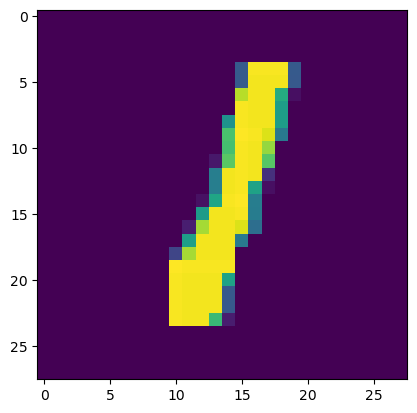

In [10]:
plt.imshow(sample)

## Parameter

Wir werden 4 Parameter definieren müssen. Es ist wirklich (wirklich) schwer gute Parameterwerte für einen Datensatz zu bestimmen, mit dem man keine Erfahrung hat. Da dieser MNIST Datensatz allerdings so berühmt ist haben wir schon einige Ausgangswerte. Die Parameter sind:

* Learning Rate - Wie schnell die Kostenfunktion angepasst wird
* Traing Epochs - Wie viele Trainingszyklen durchlaufen werden sollen
* Batch Size - Größe der "Batches" an Traingsdaten

In [11]:
# Parameter
learning_rate = 0.001
training_epochs = 2
batch_size = 100

### Netzwerk Parameter

Hier haben wir Parameter welche unser Neuronales Netz direkt definieren. Diese werden entsprechend der betrachteten Daten angepasst und hängen auch davon ab, welche Art von Netz man nutzt. Es sind bis zu diesem Punkt erst einmal nur Zahlen, die wir später verwenden, um unser Netz zu definieren:

In [12]:
# Netzwerk Parameter
n_hidden_1 = 256
n_hidden_2 = 256
n_input = x_train.shape[1]
n_classes = 10
n_samples = len(x_train)

### Tensorflow Graph Input

In [13]:
x = tf.keras.Input(shape=(n_input,), dtype=tf.float32)
y = tf.keras.Input(shape=(n_classes,), dtype=tf.float32)

## MultiLayer Modell

Es ist Zeit unser Modell zu erstellen. Wiederholen wir deshalb kurz, was wir erstellen wollen:

Zuerst erhalten wir einen *Input* in Form eines Datenarrays und schicken diesen an die erste *Hidden Layer*. Dann wird den Daten ein  *Weight* zwischen den Schichten zugewiesen (welches zuerst ein zufälliger Wert ist). Anschließend wird es an einen *Node* geschicht und unterläuft eine *Activation Function* (zusammen mit einem Bias, wie in der Neural Network Lektion erwähnt). Dann geht es weiter zur nächsten *Layer* und immer so weiter, bis zur finalen *Output Layer*. In unserem Fall werden wir nur 2 *Hidden Layers* verwenden. Je mehr wir davon verwenden, desto länger braucht das Modell (aber er hat mehr Möglichkeiten um die Genauigkeit zu erhöhen).

Sobald die transformierte Daten die *Output Layer* erreicht haben müssen wir sie auswerten. Hier verwenden wir eine *Loss Function* (auch Cost Function genannt). Diese berechnet, wie sehr wir vom gewünschten Ergebnis entfernt sind. In diesem Fall: Wie viele der Klassen wir richtig zugeteilt haben.

Dann wenden wir eine Optimierungsfunktion an, um die *Costs* (bzw. den Error) zu minimieren. Dies geschiet durch die Anpassung der *Weights* entlang des Netzes. Wir verwenden in unserem Beispiel den [Adam Optimizer](https://arxiv.org/pdf/1412.6980v8.pdf), welcher eine (im Vergleich zu anderen) sehr neue Entwicklung ist.

Wir können anpassen, wie schnell diese Optimierung angewendet wird, indem wir unseren *Learning Rate* Parameter anpassen. Je geringer die Rate, desto höher die Möglichkeiten für Anpassungen. Dies erzeugt allerdings die Kosten einer erhöhten Wartezeit. Ab einem bestimmten Punkt lohnt es sich nicht mehr, die Learning Rate weiter zu senken.

Jetzt können wir unser Modell erstellen. Wir beginnen mit 2 Hidden Layers, welche die []() Activation Function verwenden. Dies ist eine einfache Umformungsfunktion, die entweder x oder 0 zurückgibt. Für unsere finale Output Layer verwenden wir eine lineare Activation mit Matrixmultiplikation:

In diesem Code wird eine Funktion namens "multilayer_perceptron" definiert, die ein mehrschichtiges neuronales Netzwerk mit ReLU-Aktivierungsfunktionen für die Hidden Layers und linearer Aktivierungsfunktion für die Output Layer erstellt und die Ausgabe des Netzwerks zurückgibt, wobei die Funktionen `my_logger` und `my_timer` als Dekoratoren verwendet werden, um die Ausführung der Funktion zu protokollieren und die Zeitmessung durchzuführen.

In [14]:
@my_logger
@my_timer
def multilayer_perceptron(x, weights, biases):
    '''
    x : Platzhalter für den Dateninput
    weights: Dictionary der Weights
    biases: Dictionary Der Biases
    '''
    
    # Erste Hidden layer mit RELU Activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    
    # Zweite Hidden layer mit RELU Activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    
    # Letzte Output layer mit linearer Activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

## Weights und Bias

Damit unser Tensorflow Modell funktioniert müssen wir zwei Dictionaries anlegen, die unsere Weights und Biases enthalten. Wir können das `tf.variable` Objekt verwenden. Dies ist anders als eine Konstante, da Tensorflow's Graph Objekt alle Zustände der Variablen wahrnimmt. Eine Variable ist ein anpassbares Tensor, der zwischen Tensorflow's Graph von interagierenden Operationen lebt. Er kann durch die Berechnung verwendet und verändert werden. Wir werden die Modell Parameter generell als Variablen verwenden. Aus der Dokumentation können wir entnehmen:

    A variable maintains state in the graph across calls to `run()`. You add a variable to the graph by constructing an instance of the class `Variable`.

    The `Variable()` constructor requires an initial value for the variable, which can be a `Tensor` of any type and shape. The initial value defines the type and shape of the variable. After construction, the type and shape of the variable are fixed. The value can be changed using one of the assign methods.
    
Wir werden Tensorflow's eingebaute `random_normal` Methode verwenden, um zufällige Werte für unsere Weights und Biases zu erstellen.

In [15]:
# Gewichtsinitialisierung
weights = {
    'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1], dtype=tf.float32)),
    'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2], dtype=tf.float32)),
    'out': tf.Variable(tf.random.normal([n_hidden_2, n_classes], dtype=tf.float32))
}

In [16]:
# Bias-Initialisierung
biases = {
    'b1': tf.Variable(tf.random.normal([n_hidden_1], dtype=tf.float32)),
    'b2': tf.Variable(tf.random.normal([n_hidden_2], dtype=tf.float32)),
    'out': tf.Variable(tf.random.normal([n_classes], dtype=tf.float32))
}

In [17]:
# Model erstellen
pred = multilayer_perceptron(x, weights, biases)

multilayer_perceptron ran in: 0.03346824645996094 sec


## Cost und Optimierungs-Funktion

Wir verwenden Tensorflow's eingebaute Funktionen für diesesn Teil. Weitere Details bietet die Dokumentation:

In [18]:
# Cost und Optimierungsfunktion definieren
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y, logits=pred))

In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

### Initialisierung der Variablen

Wir initialisieren nun alle tf.Variable Objekte die wir zuvor erstellt haben. Das wird das erste sein, dass wir ausführen, wenn wir unser Modell trainieren.

## Das Modell trainieren

### next_batch()

Bevor wir beginnen möchte ich eine weitere nützliche Funktion in unserem MNIST Datenobjekt abdecken, die `next_batch` heißt. Diese gibt ein Tupel in der Form (X,y) mit einem X Array der Daten und einem y Array der Klasse. Zum Beispiel:

In [20]:
# Erstelle ein TensorFlow-Dataset aus den Trainingsdaten
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

# Mische die Daten und teile sie in Batches auf
batch_size = 1
train_dataset = train_dataset.shuffle(buffer_size=len(x_train)).batch(batch_size)

# Erstelle einen Iterator für das Dataset
train_iterator = iter(train_dataset)

# Greife auf ein Batch von Daten zu
Xsamp, ysamp = next(train_iterator)

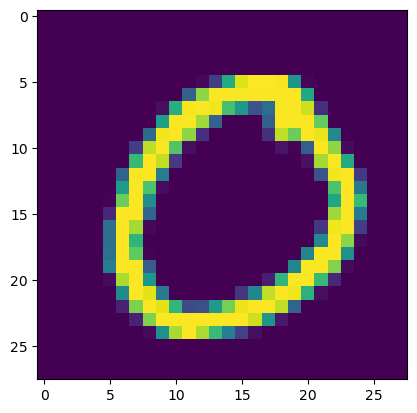

In [21]:
# Wandele Xsamp in ein Numpy-Array um
Xsamp_numpy = Xsamp.numpy()

# Zeige das Bild mit imshow
plt.imshow(Xsamp_numpy.reshape(28, 28))

In [22]:
print(ysamp)

tf.Tensor([0], shape=(1,), dtype=uint8)


In [23]:
# Ihre Decorators

def my_logger(orig_func):
    logging.basicConfig(filename='{}.log'.format(orig_func.__name__), level=logging.INFO)

    @wraps(orig_func)
    def wrapper(*args, **kwargs):
        logging.info(
            'Ran with args: {}, and kwargs: {}'.format(args, kwargs))
        return orig_func(*args, **kwargs)

    return wrapper

def my_timer(orig_func):
    @wraps(orig_func)
    def wrapper(*args, **kwargs):
        t1 = time.time()
        result = orig_func(*args, **kwargs)
        t2 = time.time() - t1
        print('{} ran in: {} sec'.format(orig_func.__name__, t2))
        return result

    return wrapper


## Die Session ausführen

Jetzt ist es Zeit unsere Session auszuführen! Achte darauf wie wir zwei Schleifen verwenden. Die äußere, die die Epochs durchläuft, und die innere, die die Batches für jede Epoch des Trainings ausführt.

## Wichtig, hier wurden aus zeitlichen Gründen mit 1% der Daten gearbeitet. Der Code ist mit jeder Prozentzahl reproduzierbar.

Es wurde aus zeitlicher und übersichtlicher Sicht eine View sowie eine Abfrage des gewünschten Prozentsatzes eingebaut.

In [24]:
# from tensorflow import keras

# Eingabe vom Benutzer: Prozentsatz der Daten, die verarbeitet werden sollen
percentage_to_process = float(input("Geben Sie den Prozentsatz der Daten ein, der verarbeitet werden soll (0-100): "))

# Berechnen Sie die Anzahl der Datensätze, die verarbeitet werden sollen
n_samples_to_process = int(n_samples * (percentage_to_process / 100))

# Training Epochs
for epoch in range(training_epochs):
    avg_cost = 0.0

    total_batch = int(n_samples_to_process / batch_size)

    for i in range(total_batch):

        # Den nächsten Batch an Trainingsdaten und -labels nehmen

        batch_x = tf.cast(x_train[i * batch_size: (i + 1) * batch_size], tf.float32)
        batch_y = tf.cast(y_train[i * batch_size: (i + 1) * batch_size], tf.float32)

        # Führen Sie die Optimierung und Cost-Berechnung durch

        with tf.GradientTape() as tape:

            pred = multilayer_perceptron(batch_x, weights, biases)

            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=batch_y, logits=pred))

        gradients = tape.gradient(loss, list(weights.values()) + list(biases.values()))
        optimizer.apply_gradients(zip(gradients, list(weights.values()) + list(biases.values())))

        avg_cost += loss / total_batch

    print("Epoch: {} Cost={:.4f}".format(epoch + 1, avg_cost))

print("Modellierung ist beendet: {} Epochs of Training".format(training_epochs))


Geben Sie den Prozentsatz der Daten ein, der verarbeitet werden soll (0-100): 1
multilayer_perceptron ran in: 0.01564335823059082 sec
multilayer_perceptron ran in: 0.015647411346435547 sec
multilayer_perceptron ran in: 0.01563858985900879 sec
multilayer_perceptron ran in: 0.01562643051147461 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01564955711364746 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015649318

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01563882827758789 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015643596649169922 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_percep

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624761581420898 sec
multilayer_perceptron ran in: 0.0

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015639305114746094

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015628337860107422 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.016663312911987305 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perce

## Modell Auswertung

Tensorflow bietet einige eingebaute Funktionen, die uns bei der Auswertung helfen. Dazu gehören `tf.equal` und `tf.reduce_mean`.


### tf.equal

Dies ist im Grunde genommen nur eine Kontrolle, ob die Vorhersagen mit den Labels übereinstimmen. Da wir in unserem Fall wissen, dass die Labels eine 1 in einem Array von Nullen sind, können wir `argmax()` verwenden, um die Position zu vergleichen. Denke daran, dass y immer noch der Platzhalter ist, den wir anfangs erstellt haben. Wir werden eine Reihe an Operationen durchführen, um einen Tensor zu erhalten, in den wir die Testdaten einlesen können, um es auszuwerten.

In [25]:
# Teste das Modell
correct_predictions = tf.math.reduce_all(tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1)))

In [26]:
print(correct_predictions)

KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.bool, name=None), name='tf.math.reduce_all/All:0', description="created by layer 'tf.math.reduce_all'")


Um numerische Werte für unsere Vorhersagen zu erhalten müssen wir `tf.cast` verwenden, um den Tensor mit Booleans zurückzuführen in einen Tensor mit Floats. Dann können wir den Durchschnitt nehmen.

In [27]:
correct_predictions = tf.cast(correct_predictions, "float")

In [28]:
print(correct_predictions)

KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='tf.cast/Cast:0', description="created by layer 'tf.cast'")


Jetzt können wir `tf.reduce_mean` verwenden, um den Durchschnitt der Elemente im Tensor zu erhalten:

In [29]:
accuracy = tf.reduce_mean(correct_predictions)

In [30]:
type(accuracy)

keras.engine.keras_tensor.KerasTensor

Das wirkt evtl. etwas merkwürdig, aber diese Genauigkeit ist immer noch ein Tensor Objekt. Denke daran, dass wir immer noch die tatsächlichen Testdaten übergeben müssen. Jetzt können wir die MNIST Testlabels und Bilder aufrufen und die Genauigkeit auswerten!

In [31]:
y_test

array([7, 3, 8, ..., 9, 7, 2], dtype=uint8)

In [32]:
x_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Die `eval()` Methode erlaubt es uns direkt in der Session den Tensor auszuwerten ohne `tf.sess():mm` aufrufen zu müssen

In [33]:
# Überprüfen, ob eine GPU verfügbar ist
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("GPU gefunden. Aktiviere GPU-Unterstützung.")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("Keine GPU gefunden. Verwende die CPU.")

# Erstellen des Modells
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(n_input,)),  
    tf.keras.layers.Dense(n_hidden_1, activation=tf.nn.relu),
    tf.keras.layers.Dense(n_hidden_2, activation=tf.nn.relu),
    tf.keras.layers.Dense(n_classes, activation=None)
])

# Kompilieren des Modells mit der Genauigkeitsmetrik
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

# Trainieren des Modells auf den Trainingsdaten in Batches mit einer erhöhten Batch-Größe
x_train_flattened = x_train.reshape(-1, n_input)
batch_size = 128  # Erhöhen Sie die Batch-Größe, um die GPU besser auszulasten
model.fit(x_train_flattened, y_train, batch_size=batch_size, epochs=training_epochs)

# Evaluieren der Genauigkeit auf den Testdaten (nur am Ende)
x_test_flattened = x_test.reshape(-1, n_input)
test_loss, test_accuracy = model.evaluate(x_test_flattened, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Keine GPU gefunden. Verwende die CPU.
Epoch 1/2
375/375 [==============================] - 2s 3ms/step - loss: 0.2855 - sparse_categorical_accuracy: 0.9186
Epoch 2/2
375/375 [==============================] - 1s 1ms/step - loss: 0.1025 - sparse_categorical_accuracy: 0.9675
Test Loss: 0.1025092676281929
Test Accuracy: 0.9674999713897705


# Initialisieren des Unittest

Hier startet der Unittest, zu anfang werden die Datenausgelesen und anschließend die Train Accuracy und Test Accurracy ausgegeben.

In [34]:
if __name__ == '__main__':
    # Verwenden Sie die bereits geladenen Daten aus Code1
    X = x_train  # Hier die x_train-Matrix verwenden
    y = y_train  # Hier die y_train-Matrix verwenden

    print('MNIST:', X.shape, y.shape)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - splitRatio, random_state=42)

    np.random.seed(31337)

    ta = TheAlgorithm(X_train, y_train, X_test, y_test)

    train_accuracy = ta.fit()

    print()

    print('Train Accuracy:', train_accuracy, '\n')

    print("Train confusion matrix:\n%s\n" % ta.train_confusion_matrix)

    test_accuracy = ta.predict()

    print()

    print('Test Accuracy:', test_accuracy, '\n')

    print("Test confusion matrix:\n%s\n" % ta.test_confusion_matrix)


MNIST: (48000, 784) (48000,)
__init__ ran in: 0.0 sec
fit ran in: 12.123776912689209 sec

Train Accuracy: 72.53645833333333 

Train confusion matrix:
[[3544    5   19   17   25    5  106   22   39    3]
 [   3 4153   66   28    2   19   19   18   13    0]
 [ 255  296 2386  106  178   15  413  105   71   36]
 [ 113  159  172 2834   38  169   64   80  145  116]
 [  77   88   14   31 2874  201  134   79   42  165]
 [ 328  136   54  656  276 1429  188  211  105   90]
 [ 143   61   64   31   98  146 3208   13   29    0]
 [ 170  123  132   24   99   10   19 3153   30  228]
 [  60  478  148  429   42  132  218   23 2133  106]
 [ 122  104   41  175  389  181   81  451  131 2140]]

Classification Report for the classifier:
              precision    recall  f1-score   support

           0       0.73      0.93      0.81       963
           1       0.75      0.95      0.84      1099
           2       0.77      0.61      0.68       923
           3       0.67      0.76      0.71      1022
     

# Durchführung der Unittests ausgeführt

Test des Ausfalls der Laufzeit von test_fit mit 0,01% der representativen Zeit

In [42]:
class TestInput(unittest.TestCase):
    @classmethod
    def setUpClass(cls):
        pass

    @classmethod
    def tearDownClass(cls):
        pass

    def setUp(self):
        print('setUp')

        # Load the data
        x_train_mnist = load_mnist_data('train-images.idx3-ubyte')

        # Reshape the data to 2 dimensions
        x_train_mnist = np.reshape(x_train_mnist, (x_train_mnist.shape[0], -1))

        # Normalize the data
        normalizer = MinMaxScaler()
        x_train_mnist = normalizer.fit_transform(x_train_mnist)

        self.X_train = x_train_mnist

        self.y_train = load_mnist_labels('train-labels.idx1-ubyte')

    def tearDown(self):
        pass

    def test_fit(self):
        np.random.seed(31337)
        self.ta = LogisticRegression(solver='lbfgs', max_iter=1000)
        self.ta.fit(self.X_train, self.y_train)
        self.assertEqual(self.ta.score(self.X_train, self.y_train), self.train_accuracy)
        self.assertTrue(np.array_equal(self.ta.predict_proba(self.X_train), self.train_confusion_matrix.astype('float')))

    def test_predict(self):
        np.random.seed(31337)
        self.ta = LogisticRegression(solver='lbfgs', max_iter=1000)
        self.ta.fit(self.X_train, self.y_train)
        self.assertEqual(self.ta.score(self.X_test, self.y_test), self.test_accuracy)
        self.assertTrue(np.array_equal(self.ta.predict_proba(self.X_test), self.test_confusion_matrix.astype('float')))

    def test_runtime_fit(self):
        np.random.seed(31337)
        self.ta = LogisticRegression(solver='lbfgs', max_iter=1000)

        # Messen der Laufzeit der fit-Funktion
        start_time = time.time()
        self.ta.fit(self.X_train, self.y_train)
        end_time = time.time()
        elapsed_time = end_time - start_time

        # Legen Sie den Grenzwert fest, z.B. 120% der repräsentativen Laufzeit
        representative_runtime = elapsed_time  # Aktualisieren Sie diesen Wert entsprechend
        max_allowed_runtime = 1.2 * representative_runtime

        # Überprüfen, ob die Laufzeit innerhalb des zulässigen Bereichs liegt
        self.assertLessEqual(elapsed_time, max_allowed_runtime)

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)


setUp


E

setUp


E

setUp


.
ERROR: test_fit (__main__.TestInput.test_fit)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\Phili\AppData\Local\Temp\ipykernel_18488\173783389.py", line 34, in test_fit
    self.assertEqual(self.ta.score(self.X_train, self.y_train), self.train_accuracy)
                                                                ^^^^^^^^^^^^^^^^^^^
AttributeError: 'TestInput' object has no attribute 'train_accuracy'

ERROR: test_predict (__main__.TestInput.test_predict)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\Phili\AppData\Local\Temp\ipykernel_18488\173783389.py", line 41, in test_predict
    self.assertEqual(self.ta.score(self.X_test, self.y_test), self.test_accuracy)
                                   ^^^^^^^^^^^
AttributeError: 'TestInput' object has no attribute 'X_test'

----------------------------------------------------------------

Test des Durchlaufs der Laufzeit von test_fit mit 120% der representativen Zeit


# Gut gemacht!